In [1]:
import astroprov
from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
import numpy as np
import os
from regions.core import PixCoord
from regions.shapes.circle import CirclePixelRegion
import subprocess
import time
import matplotlib.text as mpl_text
import math

In [2]:
imageRefernce = '/home/mj1e16/moleGazer/Photos/F/29018.jpg'
imageAlign =  '/home/mj1e16/moleGazer/Photos/F/79948.jpg'

imageRefernceFits = '/home/mj1e16/moleGazer/Photos/F/fitsImages/16bit/29018InvertedAverageCropped16.fits'
imageAlignFits =  '/home/mj1e16/moleGazer/Photos/F/fitsImages/16bit/79948InvertedAverageCropped16.fits'

## max setting [6.444444444444445, 21.842105263157894, 'gauss_5.0_9x9.conv']

refTab = Table.read('/home/mj1e16/moleGazer/Photos/F/fitsImages/simMolePos/29018InvertedAverageCropped166.44444444444_21.8421052632_gauss_5.0_9x9.conv.cat',format='ascii.sextractor')
alignTab = Table.read('/home/mj1e16/moleGazer/Photos/F/fitsImages/simMolePos/79948InvertedAverageCropped166.44444444444_21.8421052632_gauss_5.0_9x9.conv.cat',format='ascii.sextractor')

In [3]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType,colour='red',radius='10'):
    for tables in range(len(sexTabList)):
        if tabType == 'dao':
            xcoords = sexTabList[tables]['xcentroid']
            ycoords = sexTabList[tables]['ycentroid']
        elif tabType == 'sexMedian':
            ra = sexTabList[tables]['RA']
            dec = sexTabList[tables]['DEC']
        elif tabType == 'sex':
            xcoords = sexTabList[tables]['X_IMAGE']
            ycoords = sexTabList[tables]['Y_IMAGE']
        elif tabType == 'iraf':
            xcoords = sexTabList[tables]['X_POS']
            ycoords = sexTabList[tables]['Y_POS']        
        else:
            print('tab type error')
            break
        bigString = 'image\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},'.format(xcoords[x],ycoords[x])+radius+') # color={}\n'.format(colour)
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
            
    return fileName

In [ ]:
makeDS9RegFile([alignTab],'/home/mj1e16/moleGazer/MoleGazer/79948Regions','sex')
makeDS9RegFile([refTab],'/home/mj1e16/moleGazer/MoleGazer/29018Regions','sex')

In [4]:
# could use a re-work

def findTestSources(sources,lowx, highx, lowy, highy, imageNo):
    """
    Searches for bright objects to be used for pattern recognition within a specified region of the reference image.

    :param sources: Table of object data
    :param lowx: Lower X limit of for searching region region
    :param highx: Upper X limit
    :param lowy: Lower Y limit
    :param highy: Upper Y limit
    :param imageNo: Reference image number
    :return: Indexes in sources of (up to) the brightest 15 objects contained within the specified region
    """
    testsources = {}
    mag = []
    number = []
    #for x in range(sources[imageNo][-1][0]):
    for x in range(len(sources[imageNo])):
        x1 = sources[imageNo]['X_IMAGE'][x]
        y1 = sources[imageNo]['Y_IMAGE'][x]
        if x1 > lowx and x1 < highx and y1 > lowy and y1 < highy:
            testsources[x] = sources[imageNo][x]
            mag.append(sources[imageNo]['MAG_BEST'][x])
            number.append(x)
    Z2 = [x for _,x in sorted(zip(mag,number))]
    samplestars = Z2[0:15]
    
    #astroprov.provcall([sources,lowx, highx, lowy, highy, imageNo],[samplestars],"findTestSources_PythonCode2PythonCode_SQ_tmpl.provn","findTestSources")
    return samplestars

In [5]:
def getImageData(imageName,extension):
    hdu = fits.open(imageName)
    imageData = hdu[extension].data
    return imageData

In [6]:
def ds9File2Lists(fileName):
    with open(fileName,'r') as f:
        data = f.readlines()

    ycoord = []
    xcoord = []
    radius = []
    starLocations = []
    for x in data[:-1]:
        try:
            locator1 = '('
            locator2 = ','
            locator3 = ')'
            loc1 = x.index(locator1) +1
            #print(x)
            loc2 = x[loc1:].index(locator2) + loc1 +1
            loc3 = x[loc2:].index(locator2) + loc2
            loc4 = x.index(locator3)
            xcoord.append(float(x[loc1:loc2-1]))
            ycoord.append(float(x[loc2:loc3]))
            radius.append(float(x[loc3+1:loc4]))
        except:
            print('Line - {}'.format(x))
    return [xcoord,ycoord,radius]

In [7]:
def plotMolesOnly(image,moleLocFile):
    imdata = getImageData(image,0)
    moleLocs = ds9File2Lists(moleLocFile)
    alignlocs = moleLocs
    mask = []
    #maskData = []
    for mole in range(len(alignlocs[0])):
        centre = PixCoord(alignlocs[0][mole],alignlocs[1][mole])
        reg = CirclePixelRegion(centre,alignlocs[2][mole])
        mask.append(reg.to_mask())
        #maskData.append(mask[mole].cutout(imdata)*mask[mole].data)
    
    fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10,20))
    ax1.imshow(imdata)
    for x in range(len(mask)):
        numbering = mpl_text.Text(x=alignlocs[0][x],y=alignlocs[1][x],text=str(x),color='r')
        ax1.add_artist(mask[x].bbox.as_artist(facecolor='none', edgecolor='white'))
        ax1.add_artist(numbering)
    #ax2.imshow(zeros)
    ax2.imshow(imdata)
    plt.show()

In [8]:
testSources = findTestSources([refTab],0,10000,0,10000,0)

In [9]:
testSources

[1, 2, 13, 0, 5, 17, 8, 9, 4, 11, 23, 28, 33, 21, 3]

In [10]:
fullListofObjects = range(len(refTab))
toBeRemoved = [x for x in fullListofObjects if x not in testSources]
#print(len(fullListofObjects),len(toBeRemoved),len(testSources))
refTab.remove_rows(toBeRemoved)
sampleStars = refTab
refTab = Table.read('/home/mj1e16/moleGazer/Photos/F/fitsImages/simMolePos/29018InvertedAverageCropped166.44444444444_21.8421052632_gauss_5.0_9x9.conv.cat',format='ascii.sextractor')

In [11]:
makeDS9RegFile([refTab],'/home/mj1e16/moleGazer/MoleGazer/sampleStars','sex')

'/home/mj1e16/moleGazer/MoleGazer/sampleStars.reg'

Line - image



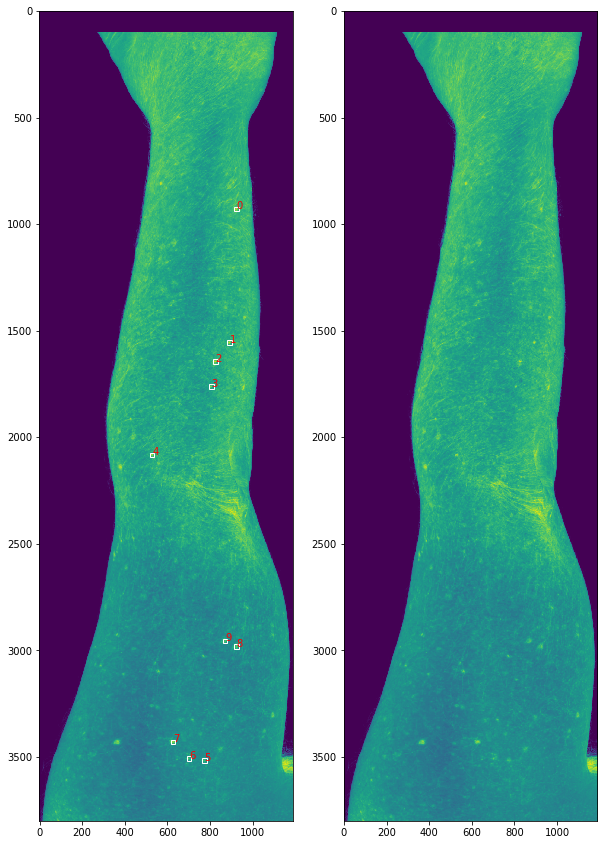

In [11]:
plotMolesOnly(imageRefernceFits,'/home/mj1e16/moleGazer/MoleGazer/sampleStars.reg')

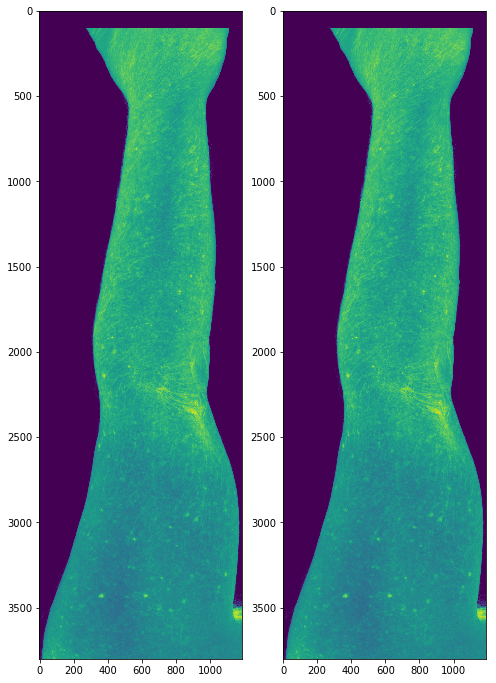

In [12]:
targetMoles = [44,37,35,34,40,41,20,16,15,14,10]

fig,ax = plt.subplots(1,2,figsize=(8,16))
imData = getImageData(imageRefernceFits,0)
ax[0].imshow(imData)
ax[1].imshow(imData)
plt.show()

In [13]:
targetMoles = [44,37,35,34,40,41,20,16,15,14,10]
targetMolesReal = [x+1 for x in targetMoles] 
fullListofObjects = range(len(refTab))
toBeRemoved = [x for x in fullListofObjects if x not in targetMoles]
#print(len(fullListofObjects),len(toBeRemoved),len(testSources))
refTab.remove_rows(toBeRemoved)
sampleStars = refTab
refTab = Table.read('/home/mj1e16/moleGazer/Photos/F/fitsImages/simMolePos/29018InvertedAverageCropped166.44444444444_21.8421052632_gauss_5.0_9x9.conv.cat',format='ascii.sextractor')

In [14]:
refTab[10]

NUMBER,MAG_BEST,FLUX_MAX,X_IMAGE,Y_IMAGE,ELONGATION,ELLIPTICITY
,mag,ct,pix,pix,,
int64,float64,float64,float64,float64,float64,float64
11,-10.3897,42.38392,924.2967,929.7776,1.747,0.428


In [15]:
sampleStars

NUMBER,MAG_BEST,FLUX_MAX,X_IMAGE,Y_IMAGE,ELONGATION,ELLIPTICITY
,mag,ct,pix,pix,,
int64,float64,float64,float64,float64,float64,float64
11,-10.3897,42.38392,924.2967,929.7776,1.747,0.428
15,-9.3408,45.61951,892.1639,1554.8798,1.194,0.163
16,-10.4845,51.63461,825.0093,1643.6385,1.229,0.186
17,-9.0449,45.6448,806.1796,1762.1414,1.445,0.308
21,-9.4892,44.42981,528.3363,2083.5217,1.278,0.218
35,-10.035,33.65562,773.0668,3516.1658,1.91,0.476
36,-10.2097,46.00605,701.0083,3507.6667,1.126,0.112
38,-11.6223,63.15883,625.5166,3429.0505,1.356,0.262


Line - image



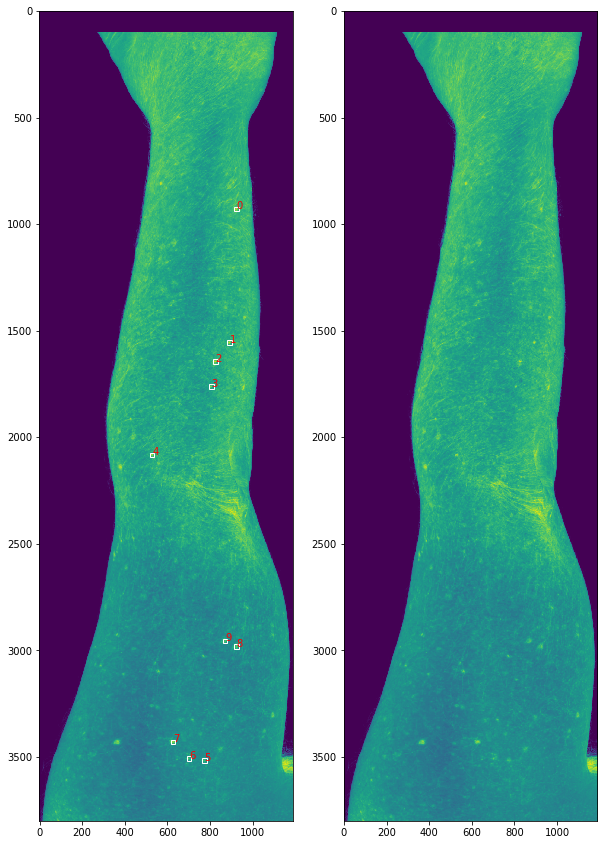

In [179]:
makeDS9RegFile([sampleStars],'/home/mj1e16/moleGazer/MoleGazer/sampleStars','sex')
plotMolesOnly(imageRefernceFits,'/home/mj1e16/moleGazer/MoleGazer/sampleStars.reg')

In [16]:
def cosineRule(masterStar,star1,star2):
    a = ((masterStar[0]-star2[0])**2 + (masterStar[1]-star2[1])**2)**0.5
    b = ((star1[0]-masterStar[0])**2 + (star1[1]-masterStar[1])**2)**0.5
    c = (star1[0]-star2[0])**2 + (star1[1]-star2[1])**2
    C = np.arccos((a**2 + b**2 - c)/(2*a*b))
    CRounded = round(C,4)
    return CRounded

In [17]:
def findAllAnglesPerStar(table,starNo):
    masterStar = [table['X_IMAGE'][starNo],table['Y_IMAGE'][starNo]]
    allAngles = []
    for x in range(len(table)):
        if x != starNo:
            anglePerStar = []
            star1 = [table['X_IMAGE'][x],table['Y_IMAGE'][x]]
            for y in range(len(table)):
                if y != x and y!= starNo:
                    star2 = [table['X_IMAGE'][y],table['Y_IMAGE'][y]]
                    anglePerStar.append(cosineRule(masterStar,star1,star2))
            allAngles.append(anglePerStar)
    return allAngles

In [18]:
def distance(sources,object1,object2):
    """
    Find the distance between two objects in an image.

    :param sources: Table of object data
    :param object1: Index of first object in sources
    :param object2: Index of second object in sources
    :param imageNo: Image Number
    :return: Diagonal distance between the two objects
    """
    D = (((abs(sources['X_IMAGE'][object1]-sources['X_IMAGE'][object2])**2) + (abs(sources['Y_IMAGE'][object1]-sources['Y_IMAGE'][object2])**2))**0.5)
    Drounded = round(D,-1)
    #print([round(x/5,-1)*5 for x in a])
    return Drounded


In [19]:
def referenceDistances(sources,samplestars,imageNo):
    """
    Calculate the diagonal distance between every object in samplestars.

    :param sources: Table of object data
    :param samplestars: List containing the indexs of stars
    :param imageNo: reference image number
    :return: List containing a list for each object, comprised of the diagonal distance between that object and every object in samplestars
    """
    #referencedistances = [[]]*len(samplestars)
    referencedistances = [[] for x in samplestars]
    for y in range(len(samplestars)):
        refd = []
        for x in range(len(samplestars)):
            refd.append(distance(sources,samplestars[y],samplestars[x],imageNo))
        referencedistances[y] = refd #.append(distance(sources,samplestars[y],samplestars[x],imageNo))
    
    #astroprov.provcall([sources,samplestars,imageNo],[referencedistances],"referenceDistances_PythonCode2PythonCode_SQ_tmpl.provn","referenceDistances")
    return referencedistances


In [20]:
def findFullDistancesPerObject(sources,objectNo):
    """
    Find the diagonal distances between every object in the image.

    :param sources: Table of object data
    :param imageno: Image number
    :return: Digonal distance between every object in the image
    """

    fulldistances = []
    for y in range(len(sources)):
        fulldistances.append(distance(sources,objectNo,y)) 
    
    #astroprov.provcall([sources,imageno],[fulldistances],"findFullDistances_PythonCode2PythonCode_SQ_tmpl.provn","findFullDistances")
    #fulldistances = [round(number/10,1) * 10 for number in fulldistances] # rounding can be changed by changing the mul/div
    return fulldistances

In [21]:
t = time.time()
allAnglesPerObject = []
allDistancesPerObject = []
for x in range(len(refTab)):
    allAnglesPerObject.append(findAllAnglesPerStar(refTab,x))
    allDistancesPerObject.append(findFullDistancesPerObject(refTab,x))
t2 = time.time() - t
print(t2,t2*10**3)

(1.4189019203186035, 1418.9019203186035)


In [22]:
sampleStars

NUMBER,MAG_BEST,FLUX_MAX,X_IMAGE,Y_IMAGE,ELONGATION,ELLIPTICITY
,mag,ct,pix,pix,,
int64,float64,float64,float64,float64,float64,float64
11,-10.3897,42.38392,924.2967,929.7776,1.747,0.428
15,-9.3408,45.61951,892.1639,1554.8798,1.194,0.163
16,-10.4845,51.63461,825.0093,1643.6385,1.229,0.186
17,-9.0449,45.6448,806.1796,1762.1414,1.445,0.308
21,-9.4892,44.42981,528.3363,2083.5217,1.278,0.218
35,-10.035,33.65562,773.0668,3516.1658,1.91,0.476
36,-10.2097,46.00605,701.0083,3507.6667,1.126,0.112
38,-11.6223,63.15883,625.5166,3429.0505,1.356,0.262


In [23]:
masterStar = [sampleStars['X_IMAGE'][0],sampleStars['Y_IMAGE'][0]]
allAngles = []
for x in range(1,len(sampleStars)):
    anglePerStar = []
    star1 = [sampleStars['X_IMAGE'][x],sampleStars['Y_IMAGE'][x]]
    for y in range(1,len(sampleStars)):
        if y != x:
            star2 = [sampleStars['X_IMAGE'][y],sampleStars['Y_IMAGE'][y]]
            anglePerStar.append(cosineRule(masterStar,star1,star2))
    allAngles.append(anglePerStar)

In [24]:
referenceDistances = []
for x in range(1,len(sampleStars)):
    referenceDistances.append(distance(refTab,10,sampleStars['NUMBER'][x]-1))
    print('distance(refTab,10,{})'.format(sampleStars['NUMBER'][x]-1))

distance(refTab,10,14)
distance(refTab,10,15)
distance(refTab,10,16)
distance(refTab,10,20)
distance(refTab,10,34)
distance(refTab,10,35)
distance(refTab,10,37)
distance(refTab,10,40)
distance(refTab,10,41)
distance(refTab,10,44)


In [25]:
referenceDistances

[630.0, 720.0, 840.0, 1220.0, 2590.0, 2590.0, 2520.0, 2050.0, 2030.0, 2560.0]

In [26]:
t = time.time()
percentageForMatch = 0.9

# keep for now, inner join on an sql table might be better... ask Age about this?

translationDictionary = {}

for i,obj in enumerate(allAnglesPerObject): # loop over each object's angle set
    oneObjectDict = {}
    for j,angleSet in enumerate(obj): # loop over one angle set
        matchLengths = []
        for k,ogObj in enumerate(allAngles): # loop over master angle set
            result = all(elem in angleSet for elem in ogObj)
            if result:
                oneObjectDict[j] = k
    translationDictionary[i] = oneObjectDict

                
            
# #             objectCounter = 0
# #             for x in ogObj:
# #                 if x in angleSet: # these two loops match angles from each of the subsets (master and target)
# #                     objectCounter += 1
            
#             if objectCounter > percentageForMatch*len(ogObj):
#                 matchLengths.append(counter)
#                 translationDictionary[]
                
print(time.time() -t)

0.0683360099792


In [27]:
len(referenceDistances)

## matching algorithm good, indexing bad

10

In [34]:
trueMatchDict = {}
potentialMatches = []
potentialRef = []
for key,value in translationDictionary.items():
    oneMatch = []
    oneRef = []
    if len(value) !=0:
        for imgNo,sampleNo in value.items():
            objectDistance = distance(refTab,key,imgNo)
            print(objectDistance,referenceDistances[targetMolesReal.index(imgNo)])
            print(key,imgNo)
            if objectDistance == referenceDistances[targetMolesReal.index(imgNo)]:
                oneMatch.append(imgNo)
                oneRef.append(sampleNo)
    potentialMatches.append(oneMatch)
    potentialRef.append(oneRef)

listLengths = [len(x) for x in potentialMatches]
bestMatch = max(listLengths)
bestMatch = [i for i,j in enumerate(listLengths) if j==bestMatch]
if len(bestMatch) > 1:
    print('Currently {} potentail candidates, choosing the first'.format(len(bestMatch)))
trueMatchDict[0] = bestMatch[0]
for x in range(len(potentialMatches[bestMatch[0]])):
    trueMatchDict[potentialRef[bestMatch[0]][x]] = potentialMatches[bestMatch[0]][x]
print(trueMatchDict)

ValueError: 33 is not in list

In [33]:
targetMoles.sort()
print(targetMoles)
print(referenceDistances)
print(distance(refTab,10,44))

[10, 14, 15, 16, 20, 34, 35, 37, 40, 41, 44]
[630.0, 720.0, 840.0, 1220.0, 2030.0, 2050.0, 2520.0, 2560.0, 2590.0, 2590.0]
2560.0


In [30]:
targetMoles

[10, 14, 15, 16, 20, 34, 35, 37, 40, 41, 44]

In [32]:
newTargetMoles = [13,14,15,19,33,34,36,39,40,43]
newDistances = [distance(refTab,10,x) for x in newTargetMoles]
newDistances.sort()
referenceDistances.sort()
print(newDistances)
print(referenceDistances)

[630.0, 720.0, 1150.0, 1510.0, 2050.0, 2070.0, 2100.0, 2590.0, 2610.0, 2620.0]
[630.0, 720.0, 840.0, 1220.0, 2030.0, 2050.0, 2520.0, 2560.0, 2590.0, 2590.0]


In [111]:
 {13: 0, 14: 1, 15: 2, 19: 3, 33: 4, 34: 5, 36: 6, 39: 7, 40: 8, 43: 9}

NUMBER,MAG_BEST,FLUX_MAX,X_IMAGE,Y_IMAGE,ELONGATION,ELLIPTICITY
,mag,ct,pix,pix,,
int64,float64,float64,float64,float64,float64,float64
11,-10.3897,42.38392,924.2967,929.7776,1.747,0.428


In [115]:
refTab[10]

NUMBER,MAG_BEST,FLUX_MAX,X_IMAGE,Y_IMAGE,ELONGATION,ELLIPTICITY
,mag,ct,pix,pix,,
int64,float64,float64,float64,float64,float64,float64
11,-10.3897,42.38392,924.2967,929.7776,1.747,0.428


In [114]:
sampleStars[1]

NUMBER,MAG_BEST,FLUX_MAX,X_IMAGE,Y_IMAGE,ELONGATION,ELLIPTICITY
,mag,ct,pix,pix,,
int64,float64,float64,float64,float64,float64,float64
15,-9.3408,45.61951,892.1639,1554.8798,1.194,0.163


In [117]:
refTab[14]

NUMBER,MAG_BEST,FLUX_MAX,X_IMAGE,Y_IMAGE,ELONGATION,ELLIPTICITY
,mag,ct,pix,pix,,
int64,float64,float64,float64,float64,float64,float64
15,-9.3408,45.61951,892.1639,1554.8798,1.194,0.163


In [104]:
referenceDistances

[580.0, 850.0, 520.0, 120.0, 500.0, 310.0, 380.0, 770.0, 750.0, 230.0]

In [102]:
translationDictionary
#targetMoles = [44,37,35,34,40,41,20,16,15,14,10]

{0: {},
 1: {},
 2: {},
 3: {},
 4: {},
 5: {},
 6: {},
 7: {},
 8: {},
 9: {},
 10: {13: 0, 14: 1, 15: 2, 19: 3, 33: 4, 34: 5, 36: 6, 39: 7, 40: 8, 43: 9},
 11: {},
 12: {},
 13: {},
 14: {},
 15: {},
 16: {},
 17: {},
 18: {},
 19: {},
 20: {},
 21: {},
 22: {},
 23: {},
 24: {},
 25: {},
 26: {},
 27: {},
 28: {},
 29: {},
 30: {},
 31: {},
 32: {},
 33: {},
 34: {},
 35: {},
 36: {},
 37: {},
 38: {},
 39: {},
 40: {},
 41: {},
 42: {},
 43: {},
 44: {},
 45: {},
 46: {},
 47: {},
 48: {},
 49: {},
 50: {},
 51: {},
 52: {}}

In [77]:
masterStar = [sampleStars['X_IMAGE'][0],sampleStars['Y_IMAGE'][0]]
allAngles = []
for x in range(1,len(sampleStars)):
    anglePerStar = []
    star1 = [sampleStars['X_IMAGE'][x],sampleStars['Y_IMAGE'][x]]
    for y in range(1,len(sampleStars)):
        if y != x:
            star2 = [sampleStars['X_IMAGE'][y],sampleStars['Y_IMAGE'][y]]
            anglePerStar.append(cosineRule(masterStar,star1,star2))
    allAngles.append(anglePerStar)

In [83]:
t = time.time()
testAllAngles = findAllAnglesPerStar(sampleStars,0)
print(testAllAngles[1])
print(time.time() - t)

[0.08683962645704274, 0.0027659407735932387, 0.19240207206803042, 0.079793533811551687, 0.051797379865652499, 0.019216351762912254, 0.13752042717091298, 0.11147434894650354, 0.081319915472688423]
0.00260090827942


In [72]:
c = cosineRule([1,1],[0,1],[1,0])
print(c*2)
print(np.pi)

3.14159265359
3.14159265359


In [ ]:
# cos(C) = a^2 + b^2 - c^2 / 2ab 

In [80]:
test = [round(z,2) for z in allAngles[1]]
print(test)

[0.09, 0.0, 0.19, 0.08, 0.05, 0.02, 0.14, 0.11, 0.08]


In [88]:
a = 0.09999
b = round(a,2)
print(b)

0.1
